In [1]:
import csv
import matplotlib.pyplot as plt
import nltk
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
# import nltk
# nltk.download('stopwords')

pandas.set_option('display.max_rows', 1000)

# loading the dataset
dataset = pandas.read_csv("newDataset.csv",sep=',',usecols=['tweet','label'])
dataset.tweet=dataset.tweet.str.lower()
#print(type(dataset))
print(f"Number of tweets: {len(dataset)}")
display(dataset)

Number of tweets: 1004


,tweet,label
0,vaccini: il successo della brexit premetterà a...,1
1,aifa autorizza il vaccino astrazeneca ma ne ra...,1
2,vaccini mentre l'eu cerca (tra l'altro senza s...,0
3,si andrebbe presumibilmente ben oltre l'anno. ...,2
4,"oggi 30 gennaio , ho ricevuto la seconda dose ...",1
...,...,...
999,the_huge_ giusepperisso vivianabillo se una pe...,2
1000,covid-19: la cina approva il suo primo vaccino...,2
1001,ponytaele ladyonorato che senso avrebbe questa...,2
1002,coolo_fun lilianaarmato chetempochefa lei si v...,1


In [2]:
italian_stemmer = SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

In [3]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted', zero_division = 0),
           'recall' : make_scorer(recall_score, average = 'macro'), 
           'f1_score' : make_scorer(f1_score, average = 'macro')
          }

def print_metrics(scores):
    print(f'accuracy on test set: {scores["test_accuracy"].mean():.3f} +/- {scores["test_accuracy"].std()*2:.3f}')
    print(f'precision on test set: {scores["test_precision"].mean():.3f} +/- {scores["test_precision"].std()*2:.3f}')
    print(f'recall on test set: {scores["test_recall"].mean():.3f} +/- {scores["test_recall"].std()*2:.3f}')
    print(f'f1-score on test set: {scores["test_f1_score"].mean():.3f} +/- {scores["test_f1_score"].std()*2:.3f}')
    
def calculate_metrics(scores, name):
    if (name == "all"):
        return scores["test_accuracy"].mean(), scores["test_accuracy"].std(), scores["test_precision"].mean(), scores["test_precision"].std(), scores["test_recall"].mean(), scores["test_recall"].std(),scores["test_f1_score"].mean(), scores["test_f1_score"].std(), scores["fit_time"].mean(), scores["fit_time"].std()
    else:
        return scores[name].mean(), scores[name].std()

In [4]:
folds = 10;
max_ngram = 2;
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    
    better_scores = [0 for i in range(8)]
    better_ngram = "ngram "
    for i in range(max_ngram):
        for j in range(max_ngram):
            if j>= i :
                text_clf = Pipeline([
                    ('vect', StemmedCountVectorizer(min_df=3, analyzer="word", stop_words = set(stopwords.words('italian')),ngram_range = (i+1,j+1))),
                    ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
                    ('clf', clf),
                ])
                scores = cross_validate(text_clf, dataset.tweet, dataset.label, cv=folds, scoring = scoring)
                accuracy_mean, accuracy_std = calculate_metrics(scores, "test_accuracy")
                
                if(round(better_scores[0],1) < round(accuracy_mean,1)):
                    better_scores = calculate_metrics(scores, "all")
                    better_ngram = "ngram: (" + str(i+1) + ", " + str(j+1) + ')'
                    print(better_ngram)
                
                print(f"------- ngram = {(i+1,j+1)} -------")
                print(f"Training time: {scores['fit_time'].mean():.3f} +/- {scores['fit_time'].std():.3f} s")
                print_metrics(scores)
                
    return clf, better_ngram, better_scores 


results = []
    
for clf in (
        (svm.LinearSVC()),
        (AdaBoostClassifier()),
        (KNeighborsClassifier(n_neighbors=5)),
        (RandomForestClassifier()),
        (MultinomialNB())):
    results.append(benchmark(clf))

________________________________________________________________________________
Training: 
LinearSVC()
ngram: (1, 1)
------- ngram = (1, 1) -------
Training time: 0.508 +/- 0.014 s
accuracy on test set: 0.512 +/- 0.067
precision on test set: 0.515 +/- 0.063
recall on test set: 0.508 +/- 0.065
f1-score on test set: 0.508 +/- 0.065
------- ngram = (1, 2) -------
Training time: 1.002 +/- 0.016 s
accuracy on test set: 0.518 +/- 0.091
precision on test set: 0.522 +/- 0.086
recall on test set: 0.513 +/- 0.090
f1-score on test set: 0.513 +/- 0.090
------- ngram = (2, 2) -------
Training time: 0.517 +/- 0.006 s
accuracy on test set: 0.454 +/- 0.107
precision on test set: 0.460 +/- 0.115
recall on test set: 0.443 +/- 0.098
f1-score on test set: 0.443 +/- 0.098
________________________________________________________________________________
Training: 
AdaBoostClassifier()
ngram: (1, 1)
------- ngram = (1, 1) -------
Training time: 0.614 +/- 0.009 s
accuracy on test set: 0.446 +/- 0.059
precisio

In [5]:
#print(results)
#print((results[0][2]))

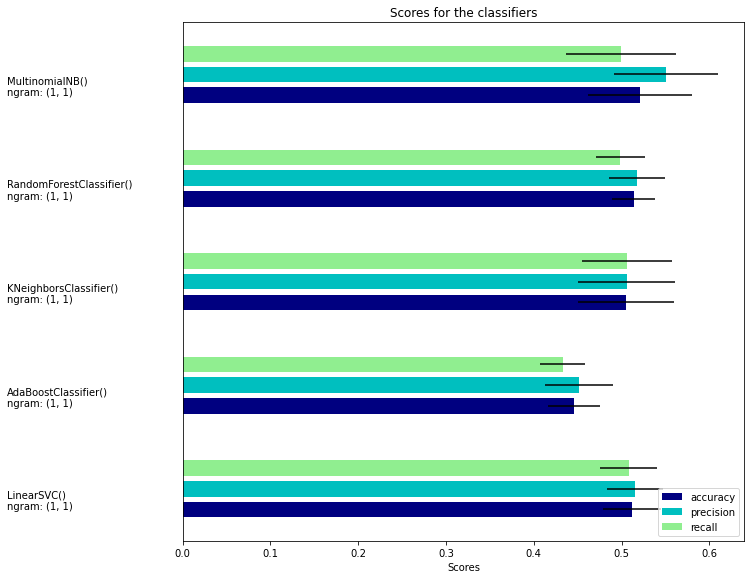

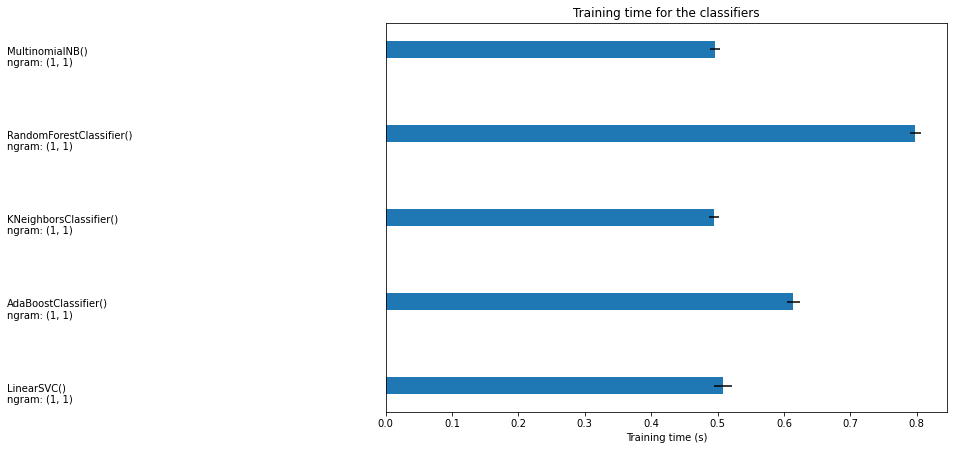

In [6]:
indices = np.arange(len(results))

results_new = [[x[i] for x in results] for i in range(3)]

clf_names, n_gram, scores = results_new
#print(results_new)

scores_new = [[x[i] for x in scores] for i in range(10)]
accuracy, std_accuracy, precision, std_precision, recall, std_recall, f1_score, std_f1_score, fit_time, std_fit_time = scores_new;

#plotting the scores
plt.figure(figsize=(12, 8))
plt.title("Scores for the classifiers")
plt.barh(indices, accuracy, .15, label="accuracy", color='navy', xerr = std_accuracy)
plt.barh(indices + .2, precision, .15, label="precision", color='c', xerr = std_precision)
plt.barh(indices + .4, recall, .15, label="recall", color='lightgreen', xerr = std_recall)
plt.yticks(())
plt.xlabel("Scores")
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.2, i, str(c) + "\n" + str(n_gram[i]))

plt.show()

#plotting the training time
plt.figure(figsize=(12, 6))
plt.title("Training time for the classifiers")
plt.barh(indices + .2, fit_time, .2, xerr = std_fit_time)
plt.xlabel("Training time (s)")
plt.yticks(())
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.57, i, str(c) + "\n" + str(n_gram[i]))

plt.show()

In [7]:
# code for confusion matrix
from sklearn.model_selection import cross_val_predict
text_clf = Pipeline([
    ('vect', StemmedCountVectorizer(min_df=2, analyzer="word", stop_words = set(stopwords.words('italian')),ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
    ('clf', MultinomialNB()),
])
y_pred = cross_val_predict(text_clf, dataset.tweet, dataset.label, cv=folds)
#conf_mat = confusion_matrix(dataset.label, y_pred, normalize="true")
conf_mat = confusion_matrix(dataset.label, y_pred)
print(conf_mat)

[[ 60 107 101]
 [ 13 210 134]
 [ 10 106 263]]


TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

In [ ]:
# code for custom stop words
stop_words = [x.strip() for x in open('stopWords.txt','r').read().split('\n')]

folds = 10
print('NAIVE BAYES CLASSIFIER - CUSTOM STOP WORDS')
for i in range(max_ngram):
    for j in range(max_ngram):
        if j>= i :
            text_clf = Pipeline([
                ('vect', StemmedCountVectorizer(min_df=2, analyzer="word", strip_accents = "unicode", stop_words = stop_words, ngram_range = (i+1,j+1))),
                ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
                ('clf', MultinomialNB()),
            ])
            scores = cross_validate(text_clf, dataset.tweet, dataset.label, cv=folds, scoring = scoring)
            print(f"------- ngram = {(i+1,j+1)} -------")
            print_metrics(scores)